In [ ]:
# Install Geopy to prepare the environment for reverse geocoding using Geopy
#!pip install geopy --quiet

In [ ]:
#!pip install geopandas

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import plotly.express as px
import plotly.graph_objects as go
import shapely
from shapely.geometry import mapping, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
# from geopy.geocoders import Nominatim
# from time import sleep

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
path = "/content/drive/My Drive/DAT_490/DATA/nyc_dac_cleaned.csv"
df = pd.read_csv(path, dtype=str)

In [ ]:
# Previously used to attempt to clean Rows using Lat/Long coordinates, however after doing this for a few columns realized this was insufficeint as these entries also used
# Lat and Long coordinates in columns that would not suffice from simple text entry corrections.
# df_cleaned = pd.read_csv(path, dtype=str)

# # Pattern match coordinate-style entries (e.g., "-73.94 40.82")
# latlon_pattern = re.compile(r"-?\d+\.\d+\s+-?\d+\.\d+")

# # Identify rows where County is lat/lon style
# def is_latlon(value):
#     if isinstance(value, str):
#         return bool(latlon_pattern.match(value.strip()))
#     return False

# coord_mask = df_cleaned['County'].apply(is_latlon)

# #Setup geocoder
# geolocator = Nominatim(user_agent="nyc_dac_cleaner")

# def reverse_geocode(coords):
#     try:
#         lon, lat = map(float, coords.split())
#         location = geolocator.reverse((lat, lon), timeout=10)
#         if location and 'address' in location.raw:
#             addr = location.raw['address']
#             return {
#                 'County': addr.get('county', None),
#                 'City_Town': addr.get('city') or addr.get('town') or addr.get('village'),
#                 'NYC_Region': 'NYC' if addr.get('state') == 'New York' else 'Rest of State'
#             }
#     except:
#         return None

# # Attempt to Repair the rows
# updated_count = 0
# for idx in df_cleaned[coord_mask].index:
#     coords = df_cleaned.at[idx, 'County']
#     info = reverse_geocode(coords)
#     if info:
#         df_cleaned.at[idx, 'County'] = info['County']
#         df_cleaned.at[idx, 'City_Town'] = info['City_Town']
#         df_cleaned.at[idx, 'NYC_Region'] = info['NYC_Region']
#         updated_count += 1
#     sleep(1)  # Respect API rate limits

# print(f"Reverse geocoding complete. {updated_count} rows repaired.")

In [ ]:
# Previously used with the above cell block
# # Save cleaned DataFrame to a new CSV file
# output_path = "/content/drive/My Drive/DAT_490/DATA/nyc_dac_cleaned.csv"
# df_cleaned.to_csv(output_path, index=False)

# print("Cleaned dataset successfully saved as 'nyc_dac_cleaned.csv'")

In [6]:
# Remove unnamed columns created from misalignment or extra commas
df_cleaned = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Final shape and column list
print(f"Cleaned shape: {df_cleaned.shape}")
df_cleaned.columns.tolist()[:10]

Cleaned shape: (4918, 64)


['GEOID',
 'DAC_Designation',
 'REDC',
 'County',
 'City_Town',
 'NYC_Region',
 'Urban_Rural',
 'Tribal_Designation',
 'Household_Low_Count_Flag',
 'Population_Count']

In [7]:
# Mapping county names to borough names
county_to_borough = {
    "New York": "Manhattan",
    "Bronx": "Bronx",
    "Kings": "Brooklyn",
    "Queens": "Queens",
    "Richmond": "Staten Island"
}

In [8]:
# Filter only NYC borough counties
df_nyc = df_cleaned[df_cleaned['County'].isin(county_to_borough.keys())].copy()
df_nyc['Borough'] = df_nyc['County'].map(county_to_borough)

# Group and count DAC vs Non-DAC designations
dac_summary = df_nyc.groupby(['Borough', 'DAC_Designation']).size().unstack(fill_value=0)
dac_summary['Total_Tracts'] = dac_summary.sum(axis=1)
dac_summary = dac_summary.sort_values(by='Total_Tracts', ascending=False)

In [9]:
# Show the result
dac_summary

DAC_Designation,Designated as DAC,Not Designated as DAC,Total_Tracts
Borough,,,
Brooklyn,308,453,761
Queens,211,458,669
Bronx,283,56,339
Manhattan,120,168,288
Staten Island,36,74,110


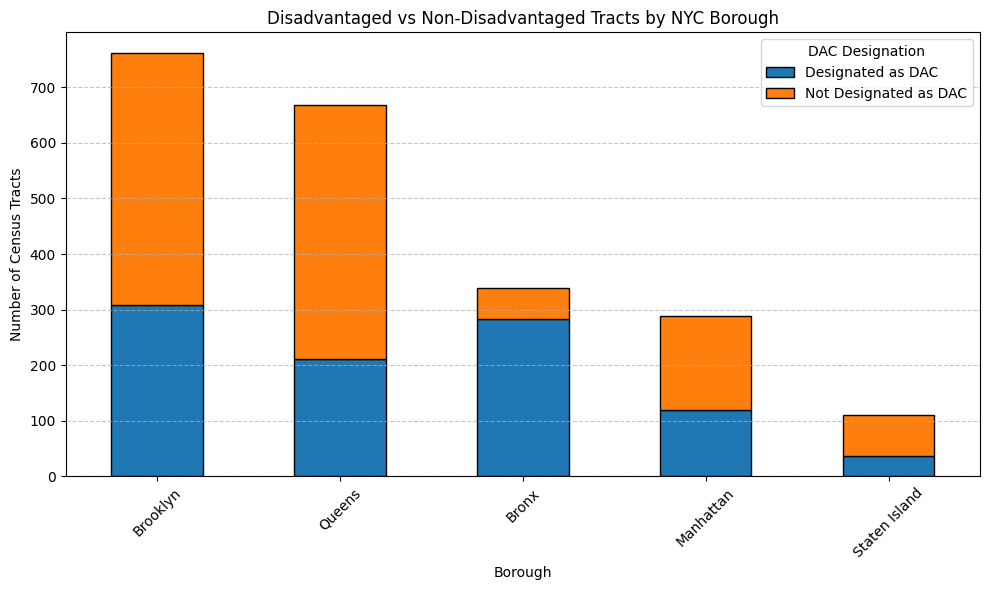

In [10]:
# Prepare DAC vs Non-DAC bar chart
dac_summary[['Designated as DAC', 'Not Designated as DAC']].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    edgecolor='black'
)

plt.title('Disadvantaged vs Non-Disadvantaged Tracts by NYC Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Census Tracts')
plt.xticks(rotation=45)
plt.legend(title='DAC Designation')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
# Convert population and internet access columns to numeric if needed
df_nyc['Population_Count'] = pd.to_numeric(df_nyc['Population_Count'], errors='coerce')
df_nyc['Internet_Access'] = pd.to_numeric(df_nyc['Internet_Access'], errors='coerce')

# Group by DAC status and describe the statistics for each attribute
population_stats = df_nyc.groupby('DAC_Designation')['Population_Count'].describe()
internet_stats = df_nyc.groupby('DAC_Designation')['Internet_Access'].describe()

In [11]:
population_stats

,count,mean,std,min,25%,50%,75%,max
DAC_Designation,,,,,,,,
Designated as DAC,958.0,4312.869520,2290.351751,155.0,2786.25,3898.0,5436.5,28109.0
Not Designated as DAC,1209.0,3546.391232,2152.903891,0.0,2092.00,3198.0,4535.0,16594.0


In [12]:
internet_stats

,count,mean,std,min,25%,50%,75%,max
DAC_Designation,,,,,,,,
Designated as DAC,949.0,0.684856,0.238884,0.0,0.531106,0.737074,0.890710,0.998739
Not Designated as DAC,1146.0,0.423819,0.260466,0.0,0.202291,0.411307,0.619851,0.996847


In [13]:
# Set seaborn style
sns.set(style="whitegrid")

<ipython-input-14-c6bc5af85884>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_nyc, x='DAC_Designation', y='Internet_Access', palette='Set2')


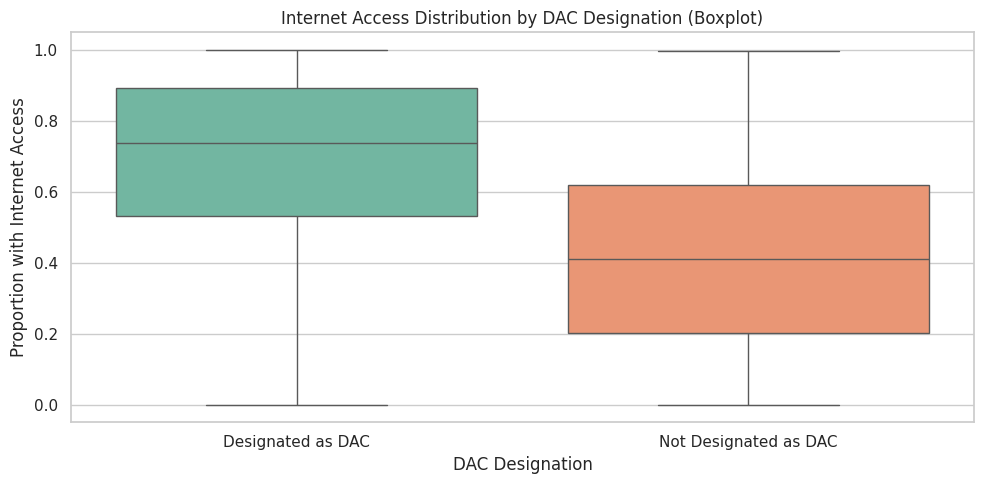

In [14]:
# Boxplot for Internet Access by DAC Designation
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_nyc, x='DAC_Designation', y='Internet_Access', palette='Set2')
plt.title('Internet Access Distribution by DAC Designation (Boxplot)')
plt.ylabel('Proportion with Internet Access')
plt.xlabel('DAC Designation')
plt.tight_layout()
plt.show()

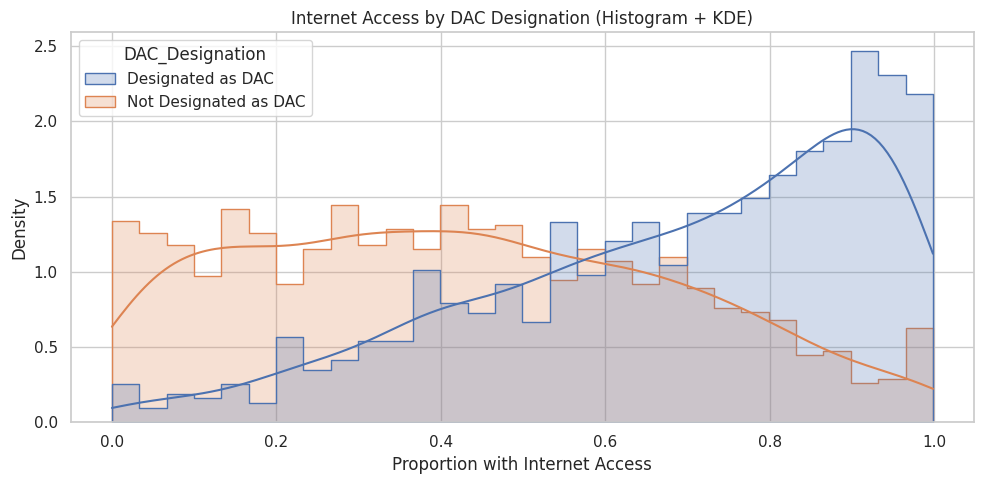

In [15]:
# KDE + Histogram plot
plt.figure(figsize=(10, 5))
sns.histplot(data=df_nyc, x='Internet_Access', hue='DAC_Designation', element='step', stat='density', common_norm=False, bins=30, kde=True)
plt.title('Internet Access by DAC Designation (Histogram + KDE)')
plt.xlabel('Proportion with Internet Access')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

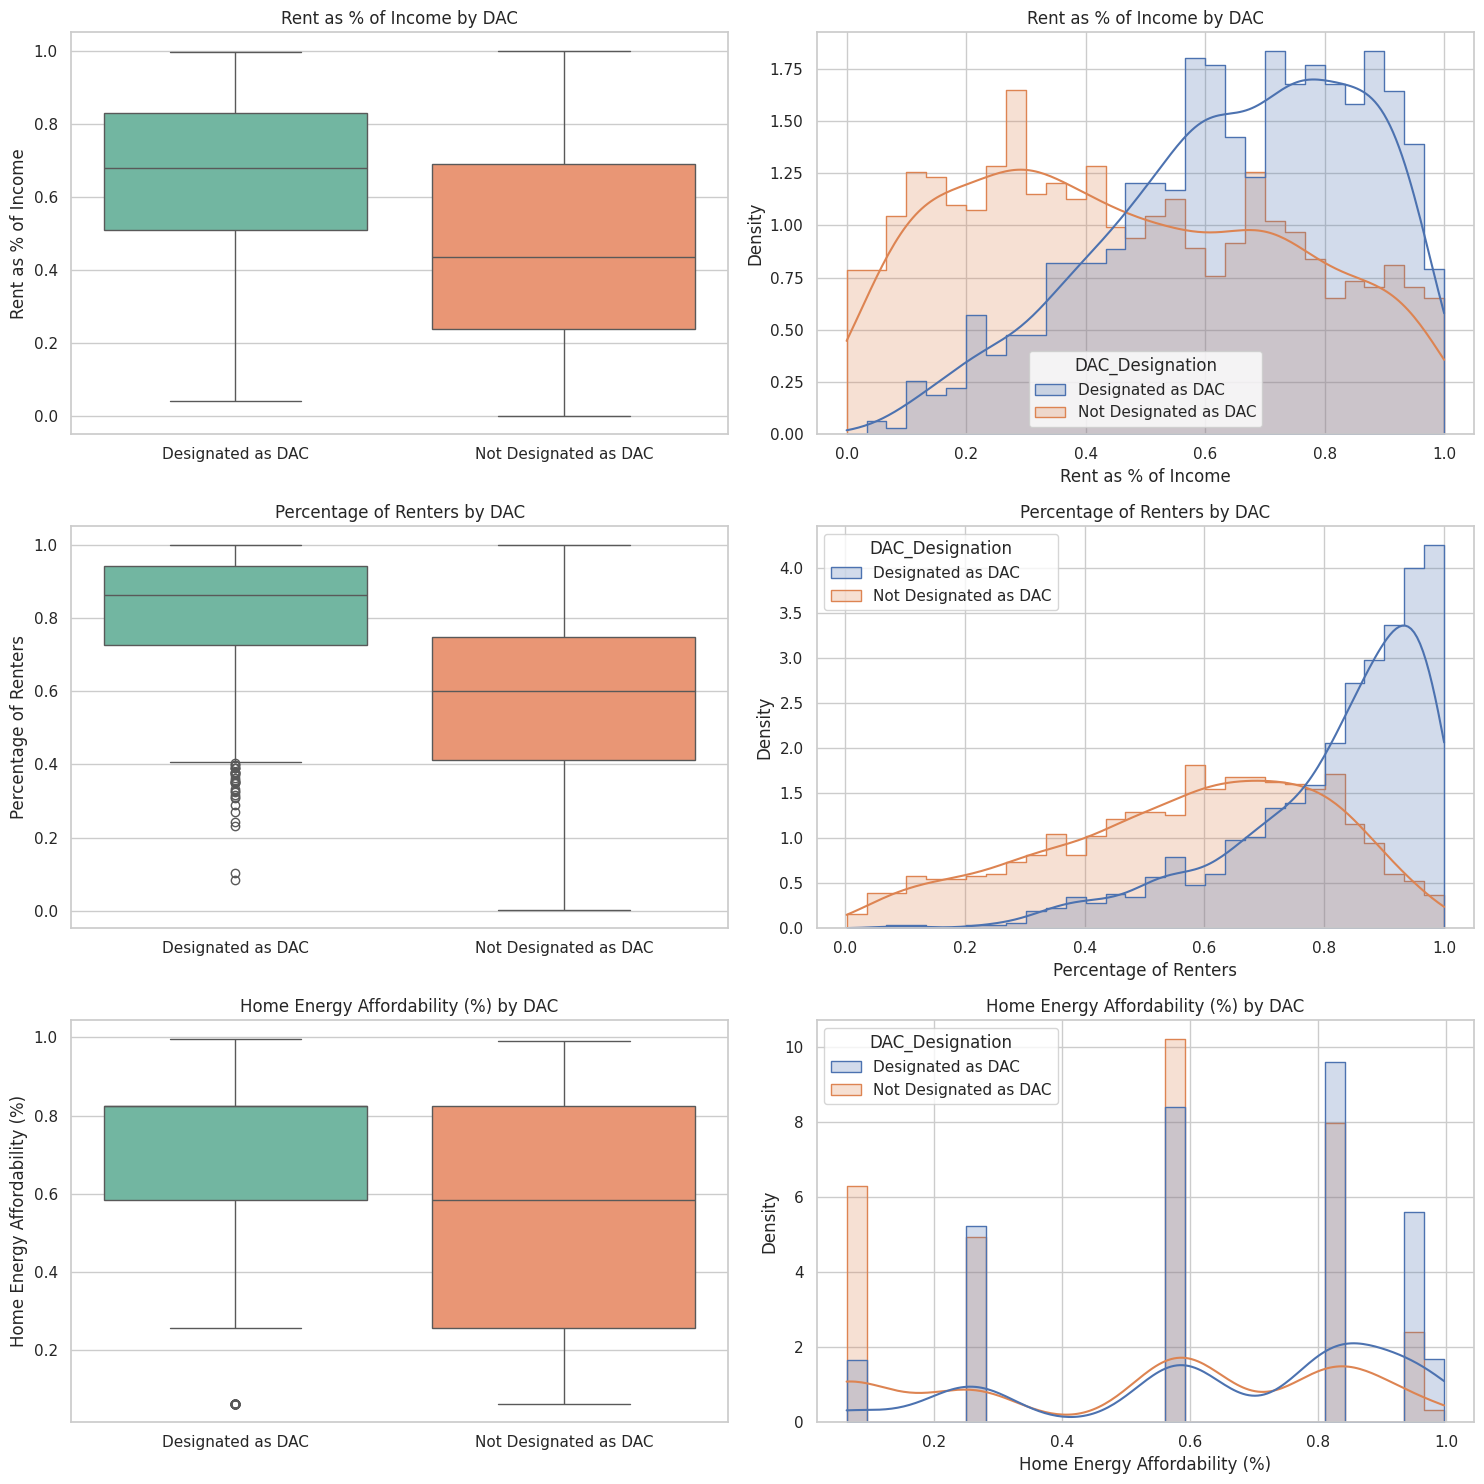

In [16]:
# Convert additional relevant fields to numeric for analysis
cols_to_convert = ['Rent_Percent_Income', 'Renter_Percent', 'Home_Energy_Affordability']
for col in cols_to_convert:
    df_nyc[col] = pd.to_numeric(df_nyc[col], errors='coerce')

# Generate boxplots and KDEs for each attribute by DAC Designation
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plot_vars = ['Rent_Percent_Income', 'Renter_Percent', 'Home_Energy_Affordability']
titles = [
    'Rent as % of Income',
    'Percentage of Renters',
    'Home Energy Affordability (%)'
]

for i, var in enumerate(plot_vars):
    # Boxplot
    sns.boxplot(data=df_nyc, x='DAC_Designation', y=var, hue='DAC_Designation', ax=axes[i, 0], palette='Set2', legend=False)
    axes[i, 0].set_title(f'{titles[i]} by DAC')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(titles[i])

    # KDE + Histogram
    sns.histplot(data=df_nyc, x=var, hue='DAC_Designation', element='step', stat='density', common_norm=False,
                 bins=30, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'{titles[i]} by DAC')
    axes[i, 1].set_xlabel(titles[i])
    axes[i, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
gdf_all = gpd.read_file("/content/drive/My Drive/DAT_490/DATA/GEO_files/tl_2020_36_tract.shp")

In [18]:
# NYC County FIPS codes for 5 boroughs
nyc_fips = ["005", "047", "061", "081", "085"]  # Bronx, Brooklyn, Manhattan, Queens, Staten Island

# Filter just NYC census tracts
gdf_tracts = gdf_all[gdf_all["COUNTYFP"].isin(nyc_fips)].copy()

In [19]:
# Make sure both have GEOID as string
df_nyc['GEOID'] = df_nyc['GEOID'].astype(str)
gdf_tracts['GEOID'] = gdf_tracts['GEOID'].astype(str)

# Merge on GEOID
gdf_merged = gdf_tracts.merge(df_nyc, on="GEOID", how="inner")

In [20]:
gdf_merged["Borough"] = gdf_merged["County"].map(county_to_borough)

In [21]:
# Separate DAC and non-DAC tracts
gdf_dac = gdf_merged[gdf_merged['DAC_Designation'] == 'Designated as DAC']
gdf_nondac = gdf_merged[gdf_merged['DAC_Designation'] != 'Designated as DAC']

In [22]:
# Set GEOID as index before filtering
# Ensure 'GEOID' is a column before setting it as index
if gdf_merged.index.name == "GEOID":
    gdf_merged = gdf_merged.reset_index()

gdf_merged = gdf_merged.set_index("GEOID")
gdf_dac = gdf_dac.set_index("GEOID")
gdf_nondac = gdf_nondac.set_index("GEOID")

In [25]:
# Create base figure
fig = go.Figure()

# Population Choropleth
fig.add_trace(go.Choroplethmapbox(
    geojson=json.loads(gdf_merged.to_json()),
    locations=gdf_merged.index,
    z=gdf_merged["Population_Count"],
    colorscale="YlOrRd",
    marker_opacity=0.6,
    marker_line_width=0,
    hovertext=gdf_merged["Borough"],
    hoverinfo="text",
    colorbar=dict(title="Population Count")
))


# DAC outline
dac_lon, dac_lat = [], []
for geom in gdf_dac.geometry:
    if isinstance(geom, Polygon):
        coords = list(geom.exterior.coords)
        lons, lats = zip(*coords)
        dac_lon += list(lons) + [None]
        dac_lat += list(lats) + [None]
    elif isinstance(geom, MultiPolygon):
        for poly in geom.geoms:
            coords = list(poly.exterior.coords)
            lons, lats = zip(*coords)
            dac_lon += list(lons) + [None]
            dac_lat += list(lats) + [None]

fig.add_trace(go.Scattermapbox(
    mode="lines",
    lon=dac_lon,
    lat=dac_lat,
    line=dict(color="red", width=2),
    name="DAC Outline",
    hoverinfo="skip"
))

# Non-DAC outline
nondac_lon, nondac_lat = [], []
for geom in gdf_nondac.geometry:
    if isinstance(geom, Polygon):
        coords = list(geom.exterior.coords)
        lons, lats = zip(*coords)
        nondac_lon += list(lons) + [None]
        nondac_lat += list(lats) + [None]
    elif isinstance(geom, MultiPolygon):
        for poly in geom.geoms:
            coords = list(poly.exterior.coords)
            lons, lats = zip(*coords)
            nondac_lon += list(lons) + [None]
            nondac_lat += list(lats) + [None]

fig.add_trace(go.Scattermapbox(
    mode="lines",
    lon=nondac_lon,
    lat=nondac_lat,
    line=dict(color="rgba(0, 0, 255, 0.4)", width=2),
    name="Non-DAC Outline",
    hoverinfo="skip"
));

In [26]:
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.5,
    mapbox_center={"lat": 40.7128, "lon": -74.0060},
    height=950,
    width=1200,
    title="NYC Census Tracts: Population (fill) with DAC Status (outlined)",
    margin={"r":0,"t":30,"l":0,"b":0},

    # Legend fix
    legend=dict(
        x=0.01,  # shift to far left
        y=0.99,
        bgcolor='white',
        bordercolor='gray',
        borderwidth=1
    )
)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [27]:
fig_no_college = go.Figure()

# Fill by Population with No College
fig_no_college.add_trace(go.Choroplethmapbox(
    geojson=json.loads(gdf_merged.to_json()),
    locations=gdf_merged.index,
    z=gdf_merged["Population_No_College"],
    colorscale="Plasma",
    marker_opacity=0.6,
    marker_line_width=0,
    hovertext=gdf_merged["Borough"],
    hoverinfo="text",
    colorbar=dict(title="Pop. No College Degree")
))

# DAC outlines
fig_no_college.add_trace(go.Scattermapbox(
    mode="lines",
    lon=dac_lon,
    lat=dac_lat,
    line=dict(color="rgba(255, 0, 0, 0.6)", width=2),
    name="DAC Outline",
    hoverinfo="skip"
))

# Non-DAC outlines
fig_no_college.add_trace(go.Scattermapbox(
    mode="lines",
    lon=nondac_lon,
    lat=nondac_lat,
    line=dict(color="rgba(0, 0, 255, 0.4)", width=2),
    name="Non-DAC Outline",
    hoverinfo="skip"
))

fig_no_college.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.5,
    mapbox_center={"lat": 40.7128, "lon": -74.0060},
    height=950,
    width=1200,
    title="NYC: Population with No College Degree (fill) and DAC Status (outline)",
    margin={"r":0,"t":30,"l":0,"b":0},
    legend=dict(x=0.01, y=0.99, bgcolor='white', bordercolor='gray', borderwidth=1)
)

fig_no_college.show()

Output hidden; open in https://colab.research.google.com to view.

In [28]:
fig_unemployment = go.Figure()

# Fill by Unemployment Rate
fig_unemployment.add_trace(go.Choroplethmapbox(
    geojson=json.loads(gdf_merged.to_json()),
    locations=gdf_merged.index,
    z=gdf_merged["Unemployment_Rate"],
    colorscale="Inferno",
    marker_opacity=0.6,
    marker_line_width=0,
    hovertext=gdf_merged["Borough"],
    hoverinfo="text",
    colorbar=dict(title="Unemployment Rate (%)")
))

# DAC outlines
fig_unemployment.add_trace(go.Scattermapbox(
    mode="lines",
    lon=dac_lon,
    lat=dac_lat,
    line=dict(color="rgba(255, 0, 0, 0.6)", width=2),
    name="DAC Outline",
    hoverinfo="skip"
))

# Non-DAC outlines
fig_unemployment.add_trace(go.Scattermapbox(
    mode="lines",
    lon=nondac_lon,
    lat=nondac_lat,
    line=dict(color="rgba(0, 0, 255, 0.4)", width=2),
    name="Non-DAC Outline",
    hoverinfo="skip"
))

fig_unemployment.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.5,
    mapbox_center={"lat": 40.7128, "lon": -74.0060},
    height=950,
    width=1200,
    title="NYC: Unemployment Rate (fill) and DAC Status (outline)",
    margin={"r":0,"t":30,"l":0,"b":0},
    legend=dict(x=0.01, y=0.99, bgcolor='white', bordercolor='gray', borderwidth=1)
)

fig_unemployment.show()

Output hidden; open in https://colab.research.google.com to view.